This notebook aims to conduct data-preprocessing steps for our PD Model, specific to machine learning. The following will be conducted. 
- Outlier / Skewness Detection & Treatment 
- Feature Engineering / Creation 
- Feature Selection (WoE & IV)
- Multicollinearity Handling 
- Low Variance Filter 
- Master Table for PD Production 

# 0. Import Libraries 

new order is outlier handling continuous raw data -> deal with them -> feature engineering (interaction features) (they are to be binned anyway) -> then feature selection via WoE and IV -> multicollinearity check + low variance check? 


In [1]:
# Import function to start Spark
from init_spark import start_spark
spark = start_spark()

from pyspark.sql.functions import (
    col, when, count, desc, isnan, isnull, lit, length, trim, lower, upper, to_date, concat_ws,  regexp_extract, sum 
)

from pyspark.sql.types import (
    StructType, StructField, StringType, DoubleType, IntegerType, DateType, NumericType
)

Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
25/07/09 10:34:52 WARN Utils: Your hostname, Chengs-MacBook-Pro.local, resolves to a loopback address: 127.0.0.1; using 10.106.14.45 instead (on interface en0)
25/07/09 10:34:52 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
:: loading settings :: url = jar:file:/Users/lunlun/Downloads/Github/Credit-Risk-Modeling-PySpark/venv/lib/python3.11/site-packages/pyspark/jars/ivy-2.5.3.jar!/org/apache/ivy/core/settings/ivysettings.xml
Ivy Default Cache set to: /Users/lunlun/.ivy2.5.2/cache
The jars for the packages stored in: /Users/lunlun/.ivy2.5.2/jars
io.delta#delta-spark_2.13 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-d99b4879-1c93-41e0-9911-90ebda003522;1.0
	confs: [default]
	found io.delta#delta-spark_2.13;4.0.0 in central
	found io.delta#delta-storage;4.0.0 in central
	found org.antlr#antlr4-runtime;4.13.1 in central
:: resolution report :: 

4.0.0


In [ ]:

# Check if Gold Delta is accessible for subsequent model building 
df = spark.read.format("delta")\
    .load("../data/gold/medallion_cleaned_lc_data_b4_model")
    
df.limit(10).toPandas()

25/07/08 23:47:24 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


,id,loan_amnt,funded_amnt,term,int_rate,installment,grade,home_ownership,annual_inc,verification_status,...,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
0,44107057,11500.0,11500.0,60,18.25,293.60,E,RENT,25000.00,Verified,...,0.0,2.0,100.0,20.0,0.0,0.0,24200.0,10307.0,16300.0,0.0
1,47038475,12000.0,12000.0,36,6.92,370.09,A,RENT,53900.00,Verified,...,0.0,5.0,100.0,0.0,0.0,0.0,212844.0,79756.0,89700.0,36144.0
2,44613469,32000.0,32000.0,60,13.99,744.42,C,MORTGAGE,88000.00,Verified,...,0.0,1.0,80.0,100.0,0.0,0.0,36700.0,25736.0,17000.0,0.0
3,43570106,17000.0,17000.0,60,10.99,369.54,B,MORTGAGE,49378.80,Verified,...,0.0,2.0,100.0,100.0,0.0,0.0,193352.0,34738.0,16800.0,21052.0
4,44986522,4375.0,4375.0,36,16.55,155.01,D,MORTGAGE,48180.00,Source Verified,...,0.0,3.0,71.0,66.7,1.0,0.0,19824.0,4318.0,3750.0,15374.0
5,44756975,1000.0,1000.0,36,9.99,32.27,B,MORTGAGE,62560.00,Verified,...,0.0,1.0,100.0,100.0,0.0,0.0,272967.0,25369.0,14200.0,33267.0
6,43370547,6300.0,6300.0,36,12.29,210.13,C,RENT,58000.00,Source Verified,...,0.0,9.0,83.0,40.0,0.0,1.0,17650.0,8586.0,8450.0,0.0
7,44956266,7000.0,7000.0,36,6.92,215.89,A,RENT,42722.05,Verified,...,0.0,1.0,93.7,0.0,1.0,0.0,34004.0,14724.0,20300.0,12999.0
8,44723575,6000.0,6000.0,36,13.99,205.04,C,RENT,41940.00,Verified,...,0.0,3.0,67.9,33.3,0.0,0.0,30923.0,20795.0,5500.0,14623.0
9,46673650,14900.0,14900.0,36,14.65,513.97,C,MORTGAGE,65000.00,Verified,...,0.0,0.0,87.5,50.0,0.0,0.0,208084.0,25978.0,5500.0,26309.0


# 1. Outlier & Skewness Detection & Treatment 


### 1.0 Mitigate Data Leak 
In credit risk modeling, there are normally features in the dataset, which 'tells our model' the answer, when it should not. Put simply, these are features that hint to the model that the borrower has defaulted in the corresponding record. This is termed as 'data leak' in the data realm and should not happen, since machine learning models are meant to predict the future, using past data. Similarly, we are trying to utilise features known at the time of loan origination, to predict a borrower's / loan's probability of default. As such, let's drop such features right from the start which aren't useful for PD Modeling.

In [ ]:
post_loan_origination_features = ['funded_amnt', 'out_prncp', 'total_pymnt', 'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'recoveries', 'collection_recovery_fee', 'last_pymnt_amnt', 'tot_coll_amt']
df = df.drop(*post_loan_origination_features) # Final Loan Balaance ? 
print('✅ Post Loan Origination Features Dropped ...')

✅ Post Loan Origination Features Dropped ...


### 1.1 Outlier & Skewness Detection 

Before feature engineering, we will be dealing with outliers and skewed distributions, which can distort credit risk models. They can dominate learning, causing bias or overfitting in our PD Model. Let's first identify features which are highly skewed. 

#### 1.1.1 Columns with Outliers 
Upon identifying highly skewed variables in our dataset, it seems we have some absurdly skewed variables. To investigate further, we will first be using `approxQuantile()` method, which is a relatively more computational effective way to identify outliers for big data. This shall be used in computing the % of outliers of these columns. We will be using the IQR method in detecting outliers. 

In [ ]:
def compute_outlier_pct(df, col_name, lower_pct=0.25, upper_pct=0.75):
    '''Computes pct of outliers per column based on IQR method '''
    
    # 1. Compute percentile bounds
    quantiles = df.approxQuantile(col_name, [lower_pct, upper_pct], 0.01)
    q1, q3 = quantiles[0], quantiles[1]
    iqr = q3 - q1 

    # 2. Obtain lower and upper bound, any data points outside of this are seen as outliers 
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    total_rows = df.count()

    return round(df.filter( (col(col_name) < lower_bound) | (col(col_name) > upper_bound) ).count() / total_rows * 100, 2) 

# 1. After cleaning missing values, find % outliers per column (sampling big data for efficiency)
sample_df = df.select([feature.name for feature in df.schema if isinstance(feature.dataType, NumericType)]).sample(fraction=0.05, seed=42) 


outliers_dict = {}

for feature in sample_df.schema: 
    col_name = feature.name 
    data_type = feature.dataType

    if isinstance(data_type, (DoubleType, IntegerType)): 
        outlier_pct = compute_outlier_pct(sample_df, col_name) 
        if outlier_pct > 0: 
            outliers_dict[col_name] = outlier_pct


print('❌ Outlier Percentage by Feature (sorted):')
for k, v in sorted(outliers_dict.items(), key=lambda item: item[1], reverse=True):
    print(f"{k}: {round(v, 2)}%")


❌ Outlier Percentage by Feature (sorted):
num_accts_ever_120_pd: 22.31%
delinq_2yrs: 18.57%
pub_rec: 15.96%
default_status: 12.2%
pub_rec_bankruptcies: 12.14%
mths_since_recent_bc: 9.21%
bc_open_to_buy: 9.19%
mo_sin_rcnt_rev_tl_op: 8.37%
pct_tl_nvr_dlq: 7.17%
mo_sin_rcnt_tl: 6.7%
total_bc_limit: 6.44%
total_rev_hi_lim: 6.43%
revol_bal: 6.38%
total_bal_ex_mort: 6.29%
avg_cur_bal: 6.08%
mo_sin_old_il_acct: 5.73%
total_il_high_credit_limit: 5.67%
mths_since_recent_inq: 5.28%
num_tl_90g_dpd_24m: 5.18%
annual_inc: 4.9%
num_bc_sats: 4.65%
num_il_tl: 4.45%
last_fico_range_high: 4.35%
last_fico_range_low: 4.35%
num_op_rev_tl: 4.19%
tot_cur_bal: 4.1%
inq_last_6mths: 4.08%
mort_acc: 4.07%
tot_hi_cred_lim: 3.89%
open_acc: 3.62%
mo_sin_old_rev_tl_op: 3.55%
num_sats: 3.54%
fico_range_low: 3.37%
fico_range_high: 3.37%
installment: 3.34%
tax_liens: 2.87%
num_actv_rev_tl: 2.77%
num_tl_op_past_12m: 2.51%
num_rev_tl_bal_gt_0: 2.5%
num_rev_accts: 2.49%
int_rate: 2.36%
num_bc_tl: 2.31%
num_actv_bc_tl: 2.2

To ensure that our WoE & IV Feature Selection produce better binning (more balanced bins) and smoother WoE (if a feature separates good and bad outcomes properly), we should visualise our distributions to understand our dataset better. 

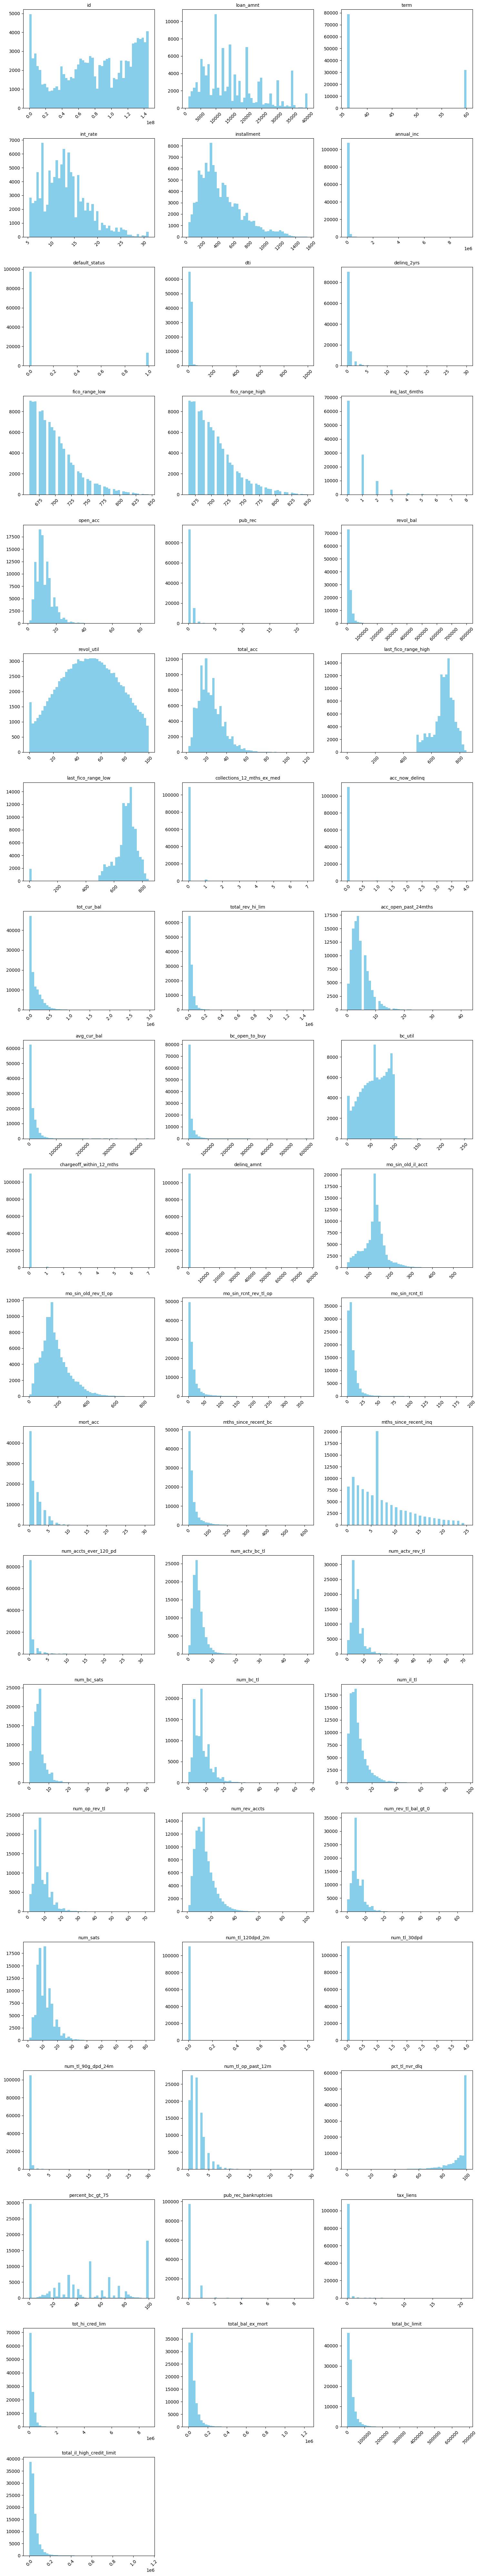

In [ ]:
# 5. Check INITIAL DISTRIBUTION OF NUMERICAL FEATURES 

import matplotlib.pyplot as plt
import pandas as pd
from pyspark.sql.types import NumericType

def display_distributions(df): 

    # 1. Select numerical columns
    numeric_cols = [field.name for field in df.schema if isinstance(field.dataType, NumericType)]

    # 2. Sample small portion of data (e.g., 5%) and convert to pandas
    sample_df = df.select(numeric_cols).sample(fraction=0.05, seed=42)
    sample_pdf = sample_df.toPandas()

    # 3. Plot histograms as subplots
    n_cols = 3  # Number of plots per row
    n_rows = (len(numeric_cols) + n_cols - 1) // n_cols

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4 * n_rows))
    axes = axes.flatten()

    for i, col_name in enumerate(numeric_cols):
        axes[i].hist(sample_pdf[col_name].dropna(), bins=50, color='skyblue')
        axes[i].set_title(col_name, fontsize=10)
        axes[i].tick_params(axis='x', rotation=45)

    # Hide any unused subplots
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()
    
display_distributions(df)

From the original distribution of our cleaned dataset, we can observe that we have many skewed features, which is common is credit risk datasets. Before dealing with skewness, it is important to handle outliers first. Skewness measures the symmetry of a feature, and a few outliers can over-inflate the skewness of a feature, rendering the skewness value inaccurate. This can lead to us blindly applying transformations to a feature, when it does harm to our PD Model. 

As such, based on the nature of an outlier, they will be dealt in different ways. 
- **Clear Data Error**: Trim 
- **Real Outlier but Rare (Domain Knowledge Based)**: Winsorise till IQR Bounds 
- **Outlier is Real & Meaningful** : Let WoE binning handle this outlier 

In [ ]:
from pyspark.sql import DataFrame
def inspect_outliers_iqr(df: DataFrame, columns: list, sample_size: int = 5):
    for col_name in columns:
        try:
            print(f"\n📊 Inspecting Outliers for Column: `{col_name}`")

            # Step 1: Calculate Q1, Q3, and IQR
            q1, q3 = df.approxQuantile(col_name, [0.25, 0.75], 0.01)
            iqr = q3 - q1
            lower = q1 - 1.5 * iqr
            upper = q3 + 1.5 * iqr

            print(f"Q1 = {q1}, Q3 = {q3}, IQR = {iqr}")
            print(f"Lower Bound = {lower}, Upper Bound = {upper}")

            # Step 2: Count outliers
            outlier_count = df.filter((col(col_name) < lower) | (col(col_name) > upper)).count()
            total_count = df.count()
            outlier_pct = round(outlier_count / total_count * 100, 2)
            print(f"Outlier Count: {outlier_count} ({outlier_pct}%)")

            # Step 3: Sample outlier values (top and bottom)
            print(f"🔼 Top Outliers (>{upper}):")
            df.filter(col(col_name) > upper).select(col_name).orderBy(col(col_name).desc()).show(sample_size)

            print(f"🔽 Bottom Outliers (<{lower}):")
            df.filter(col(col_name) < lower).select(col_name).orderBy(col(col_name)).show(sample_size)

        except Exception as e:
            print(f"❌ Could not process column `{col_name}`: {str(e)}")

outlier_columns = list(outliers_dict.keys())  # or use your own column list
inspect_outliers_iqr(df, outlier_columns)



📊 Inspecting Outliers for Column: `loan_amnt`
Q1 = 8000.0, Q3 = 20000.0, IQR = 12000.0
Lower Bound = -10000.0, Upper Bound = 38000.0
Outlier Count: 34330 (1.55%)
🔼 Top Outliers (>38000.0):
+---------+
|loan_amnt|
+---------+
|  40000.0|
|  40000.0|
|  40000.0|
|  40000.0|
|  40000.0|
+---------+
only showing top 5 rows

🔽 Bottom Outliers (<-10000.0):
+---------+
|loan_amnt|
+---------+
+---------+


📊 Inspecting Outliers for Column: `int_rate`
Q1 = 9.49, Q3 = 15.7, IQR = 6.209999999999999
Lower Bound = 0.1750000000000025, Upper Bound = 25.014999999999997
Outlier Count: 46854 (2.11%)
🔼 Top Outliers (>25.014999999999997):
+--------+
|int_rate|
+--------+
|   30.99|
|   30.99|
|   30.99|
|   30.99|
|   30.99|
+--------+
only showing top 5 rows

🔽 Bottom Outliers (<0.1750000000000025):
+--------+
|int_rate|
+--------+
+--------+


📊 Inspecting Outliers for Column: `installment`
Q1 = 250.11, Q3 = 593.21, IQR = 343.1
Lower Bound = -264.5400000000001, Upper Bound = 1107.8600000000001
Outlier

From the above, we group features with outliers into the following groups. Reasons why I grouped certain features into a category are as explained. 

Due to the uncertainty of credit risk modelers in the real world, it is often a common practice that they keep their outlier handling methods in an audit-trail such as Excel. They will come back to revisit, should model performance fails to pass the company's set threshold. A similar audit trail will be in `sandbox/model_building_audit_trail.xlsx`.

In [ ]:
# Checking for invalid values 

# df.where(col('int_rate') < 0).toPandas()
# df.where(col('installment') < 0).toPandas()
# df.where(col('annual_inc') < 0).toPandas()
# df.where(col('dti') < 0).toPandas()
# df.where(col('delinq_2yrs') > 0).toPandas()
# df.where(col('inq_last_6mths') < 0).toPandas()
# df.select(col('open_acc')).distinct().count()
# df.where(col('pub_rec') > 0).toPandas()
# df.where(col('revol_bal') <0).toPandas()
# df.where(col('total_acc') <0).toPandas()
# df.where(col('last_fico_range_low') < 300).toPandas()
# df.where(col('total_rev_hi_lim') > 83250).toPandas()
# df.where(col('acc_open_past_24mths') < 0).toPandas()
# df.where(col('avg_cur_bal') < 0).toPandas()
# df.where(col('mo_sin_old_rev_tl_op')< 0).toPandas()
# df.where((col('tot_hi_cred_lim')< 9_999_999) & (col('tot_hi_cred_lim') > 200_000)).toPandas()
# df.where((col('tot_hi_cred_lim')< 0)).toPandas()
# df.where((col('total_bc_limit')< 0)).toPandas()

In [ ]:
def winsorise_col(df, col_name,operator: str,  condition_val, final_val):
    """
    Winsorises a column by replacing values above a certain condition with a final value.
    
    Args:
        df (DataFrame): The input DataFrame.
        col_name (str): The name of the column to winsorise.
        condition_val (float): The value above which to replace with final_val (cut-off)
        final_val (float): The value to replace with.
        
    Returns:
        DataFrame: The DataFrame with the winsorised column.
    """
    print("✅ Winsorising column:", col_name, "...")
    
    if operator == '<':
        return df.withColumn(col_name, when(col(col_name) < condition_val, final_val).otherwise(col(col_name)))
    
    elif operator == '>':
        return df.withColumn(col_name, when(col(col_name) > condition_val, final_val).otherwise(col(col_name)))

def retain_rows(df: DataFrame, col_name: str, condition_val: float, operator: str) -> DataFrame:
    """
    Retains rows in the DataFrame where the specified column meets a condition.

    Returns:
        DataFrame: The DataFrame with the specified rows dropped.
    """
    
    if operator == '<=':
        return df.filter(col(col_name) <= condition_val)    
    
    elif operator == '<':
        return df.filter(col(col_name) < condition_val)
    
    elif operator == '>':
        return df.filter(col(col_name) > condition_val)
    
    elif operator == '>=':
        return df.filter(col(col_name) >= condition_val)
    
    else:
        raise ValueError("Operator must be '>=' or '<='")


In [ ]:
# Individual Outlier Handling
from pyspark.sql import functions as F

# DTI Outlier Handling
df = retain_rows(df, 'dti', 120, '<=')  # Drop rows where dti > 120
df = winsorise_col(df, 'dti','>', 100, 100)  # Winsorise dti > 100 to 100


# Only allow fico_scores between 300 and 850
df = df.filter((col("last_fico_range_high") <= 850) & (col("last_fico_range_high") >= 300))
df = df.filter((col("last_fico_range_low") <= 850) & (col("last_fico_range_low") >= 300))

# total_rev_hi_lim 
df = df.filter(col("total_rev_hi_lim") < 9_999_999.0) # likely placeholders / data error 

# months since oldest installment account opened
df = df.filter(col("mo_sin_old_il_acct") < 999)  # Drop likely placeholders 
df = df.filter(col("mo_sin_old_rev_tl_op") < 999)  # Drop likely placeholders 

# high credit limit 
df = df.filter(col("tot_hi_cred_lim") < 9_999_999.0)  


✅ Winsorising column: dti ...


It seems that each feature still have outliers. However, this is often normal in credit risk datasets, and it will be illogical if we simply drop them simply because we are outliers. Even if they are outliers, certain data points act as a crucial indicator to PD modeling, e.g. extremely high `dti` can signal high probability of default. 

In real life, it seems that credit risk modelers check the WoE and IV of each feature or build their PD models first, before improving on it, and improving their outlier handling methods manually per feature. For now, let's check out the skewness of features in our dataset. 

#### 1.1.2 Identifying Highly Skewed Features

In [ ]:
from pyspark.sql.functions import skewness
from pprint import pprint 

numeric_columns = [field.name for field in df.schema.fields if isinstance(field.dataType, NumericType)]


# Compute skewness for each numeric column 
for column in numeric_columns: 
    
    skew_val = df.select(skewness(col(column))).collect()[0][0]
    
    if skew_val is not None and abs(skew_val) >= 1: 
        skew_val = round(skew_val, 2)  # Round to 2 decimal places
        print(f"{column}: {skew_val} 🚩")
        
    else: 
        print(f"{column}: {skew_val}")
        

id: -0.27347520299971634
loan_amnt: 0.7762160804475983
term: 0.9468956579445807
int_rate: 0.7736914597460322
installment: 0.9993678581200869
annual_inc: 498.52 🚩
default_status: 2.52 🚩
dti: 1.09 🚩
delinq_2yrs: 5.91 🚩
fico_range_low: 1.18 🚩
fico_range_high: 1.18 🚩
inq_last_6mths: 1.82 🚩
open_acc: 1.32 🚩
pub_rec: 10.81 🚩
revol_bal: 11.31 🚩
revol_util: -0.016018570285337316
total_acc: 1.0 🚩
last_fico_range_high: -0.6179549127459487
last_fico_range_low: -0.6179981313750252
collections_12_mths_ex_med: 14.14 🚩
acc_now_delinq: 22.89 🚩
tot_cur_bal: 2.95 🚩
total_rev_hi_lim: 6.11 🚩
acc_open_past_24mths: 1.43 🚩
avg_cur_bal: 3.67 🚩
bc_open_to_buy: 3.78 🚩
bc_util: -0.28085757647975373
chargeoff_within_12_mths: 18.22 🚩
delinq_amnt: 103.83 🚩
mo_sin_old_il_acct: 0.34367549926663765
mo_sin_old_rev_tl_op: 1.03 🚩
mo_sin_rcnt_rev_tl_op: 3.62 🚩
mo_sin_rcnt_tl: 4.63 🚩
mort_acc: 1.82 🚩
mths_since_recent_bc: 3.56 🚩
mths_since_recent_inq: 1.02 🚩
num_accts_ever_120_pd: 5.51 🚩
num_actv_bc_tl: 1.53 🚩
num_actv_rev

#### 1.1.3 Visualising Distributions 

To ensure that our WoE & IV Feature Selection produce better binning (more balanced bins) and smoother WoE (if a feature separates good and bad outcomes properly), we should visualise our distributions to understand our dataset better. 

Before that, let's obtain some base features from our dataset. 

First, a common derived feature in credit risk is the credit history length of the borrower at the time of loan issuance. Normally, it would be safe to say that loans with borrowers with a longer credit history has a lower probability of default. Hence, this can be taken into account as 1 of the features of the dataset. We can compute this as the difference between `issue_d` and `earliest_cr_line`. 

In [ ]:
import pyspark.sql.functions as F  

df = df.withColumn('credit_history_years',    F.months_between(F.col('issue_d'), F.col('earliest_cr_line')) / 12   )

Second, it seems that we have 2 features related to FICO Scores: `fico_range_low` and `fico_range_high`. Upon further research, these features do not represent the lowest and highest scores ever recorded for a borrower, but rather the lower and upper bounds of a small range in which the borrower’s actual FICO score falls. Banks record these due to privacy concerns, through a 5 point window, as shown below. As such, it seems that we just need to average these 2 values, to minimise redundancy and multicollinearity. The same applies for `last_fico_range_high` and `last_fico_range_low`, we shall average them out first, since any multicollinearity will be detected later on anyways.

In [ ]:
df = df.withColumn('fico_score',  (col('fico_range_low') + col('fico_range_high')) / 2  )
df = df.drop( col("fico_range_low")   , col('fico_range_high') ) 

# Last Credit Pull FICO Score 
df = df.withColumn('last_fico_score',  (col('last_fico_range_low') + col('last_fico_range_high')) / 2  )
df = df.drop( col("last_fico_range_low")   , col('last_fico_range_high') ) 

Now, lets visualise the distributions of our features. 

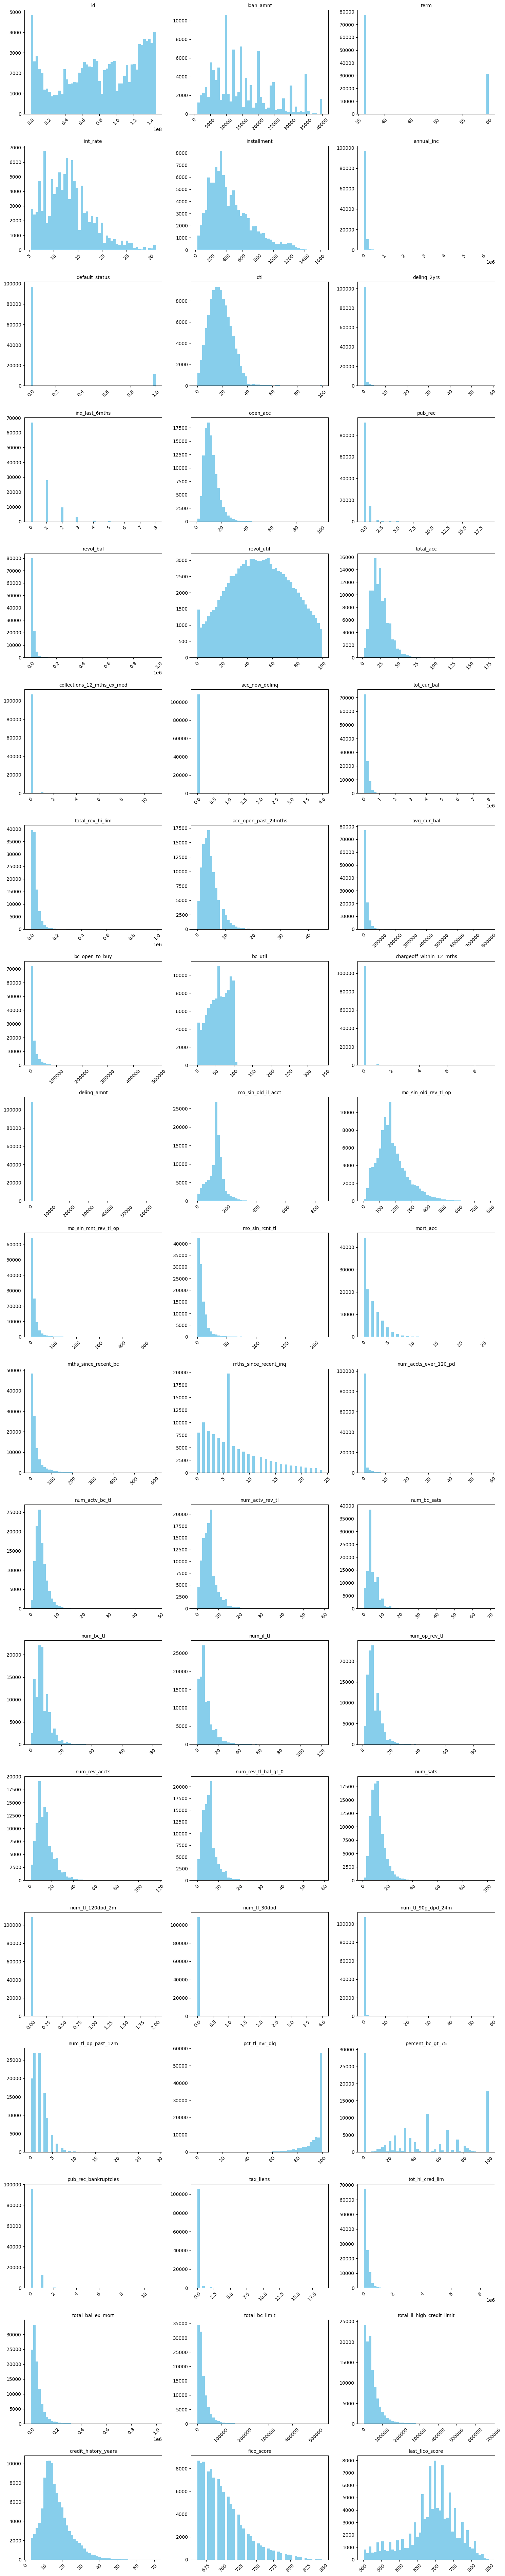

In [ ]:

display_distributions(df)


Now, let's deal with skewness issues. We will group the following numerical features into the following categories
- **Highly Right Skewed (Pct / Probability)**: Logit Transformation
- **Highly Right Skewed (Continuous Feature)**: Log Transformation, Else Box-Cox 
- **Discrete Variables**: WoE binning in Feature Selection 


⚠️ At this checkpoint, I went on the internet and continued researching about the ideal order of outlier detection -> skewness handling -> WoE & IV Feature Selection. However, I realised that WoE conducts binning of continuous variables and are robust to outliers and skewness. They bin outliers into a separate bin and skewness transformation would not be required. Considering the fact that our outlier handling only dealt with a few features and removed potential placeholders, the code shall not be deleted. Additionally, should the model be instable, skewness shall be looked into in detail later on in the process. 

# 2. WoE & IV Feature Selection

Before feature selection, it is important I understand certain rules I have to adhere to for WoE. 
1) **Monotonicity**: As `feature` bins/values increase, WoE should increase as well. Just like how Logistic Regression Model fits an S-shaped curve, feature and target class should move in the same direction. Else, it violates linearity assumption of Logistic Regression 

2) **No 0 in Good / Bad Counts (Each Bins)**: Required to compute WoE accurately. Prevents division of 0 in WoE calculation 

3) **Group bins of similar WoE together = Coarse binning**

4) **Each bin should have at least 0.5% of good class & bad class**: Drop if unimportant / Merge 

Additionally, I shall follow the following rules for selecting my features for PD Modeling (Logistic Regression)

![Feature Selection](https://media.licdn.com/dms/image/v2/D5612AQEnsMrGYt9wxw/article-inline_image-shrink_1500_2232/article-inline_image-shrink_1500_2232/0/1659097050621?e=1757548800&v=beta&t=4GwB73k9LWlDDgdydkU2boqr8GAnIr-Qc73Yem58PwI)

In [16]:
from pyspark.ml.feature import Bucketizer
from pyspark.sql.functions import col
from monotonic_binning import monotonic_binning

# 1. Sample to pandas
sample_pd = (
    df
    .select("age", "target")              # replace with your col names
    .sample(fraction=0.3, seed=42)
    .toPandas()
)

# 2. Apply monotonic binning (optimize IV, force monotonic trend)
bin_result = monotonic_binning(
    x=sample_pd["age"],
    y=sample_pd["target"],
    max_bins=8,
    min_bin_pcnt=0.05
)

bin_table = bin_result["binning_table"]
cutpoints = [-float("inf")] + bin_result["splits"] + [float("inf")]
woe_map = bin_result["woe_map"]    # {bin_number: WOE value}

# 3. Apply bins in PySpark
bucketizer = Bucketizer(
    splits=cutpoints,
    inputCol="age",
    outputCol="age_bin"
).setHandleInvalid("keep")

df = bucketizer.transform(df)

# 4. Create WOE lookup DataFrame
woe_data = [(i, float(woe_map[i])) for i in range(len(woe_map))]
woe_df = spark.createDataFrame(woe_data, ["age_bin", "age_woe"])

# 5. Join WOE back to DataFrame
df = df.join(woe_df, on="age_bin", how="left").drop("age_bin")

# 6. Total IV for the feature (if needed)
total_iv = bin_table["iv"].sum()
print("Total IV for age:", total_iv)



ModuleNotFoundError: No module named 'pyspark.ml'

In [36]:
from pyspark.sql.functions import  log, sum as spark_sum

totals = df.agg(
    spark_sum(when(col('default_status') == 0, 1).otherwise(0)).alias('total_non_defaulted'),
    spark_sum(when(col('default_status') == 1, 1).otherwise(0)).alias('total_defaulted')
).collect()[0]

total_good = totals['total_non_defaulted']
total_bad = totals['total_defaulted']
print(f"\nTotal Non-Defaulted Loans: {total_good}\nTotal Defaulted Loans: {total_bad}")


Total Non-Defaulted Loans: 1947170
Total Defaulted Loans: 236018


In [37]:
def woe_iv_for_binned_var(df, bin_col, target_col):
    
    # Calculate total non-defaulted and defaulted count 
    totals = df.agg(
        spark_sum(when(col(target_col) == 0, 1).otherwise(0)).alias('total_non_defaulted'),
        spark_sum(when(col(target_col) == 1, 1).otherwise(0)).alias('total_defaulted')
    ).collect()[0]
    
    total_good = totals['total_non_defaulted']
    total_bad = totals['total_defaulted']

    # Group by bin and calculate good/bad per bin
    grouped = df.groupBy(bin_col).agg(
        spark_sum(when(col(target_col) == 0, 1).otherwise(0)).alias('non_defaulted_count'),
        spark_sum(when(col(target_col) == 1, 1).otherwise(0)).alias('defaulted_count')
    )

    # Calculate distributions, WoE, and IV
    result = grouped.withColumn('non_defaulted_pct', col('non_defaulted_count') / total_good)\
        .withColumn('defaulted_pct', col('defaulted_count') / total_bad)\
        .withColumn('woe', when(col('non_defaulted_pct') == 0, 0)
                             .when(col('defaulted_pct') == 0, 0)
                             .otherwise(log(col('non_defaulted_pct') / col('defaulted_pct'))))\
        .withColumn('iv_bin', (col('non_defaulted_pct') - col('defaulted_pct')) * col('woe'))

    # Calculate total IV
    iv = result.agg(spark_sum('iv_bin').alias('iv')).collect()[0]['iv']
    return result, iv

In [17]:
def woe_iv_for_numerical_features(df, numerical_features, target_col='default_status'):
    iv_dict = {}
    
    for feature in numerical_features:
        # Assuming the numerical features are already binned and named as feature+'_bin'
        binned_col = feature + '_bin'
        if binned_col in df.columns:
            woe_df, iv = woe_iv_for_binned_var(df, binned_col, target_col) # returns woe & iv score for e.g. `dti`
            iv_dict[feature] = iv
            print(f"WoE and IV for {feature} (binned as {binned_col}):")
            # Sort by bin column before displaying
            woe_df.orderBy(binned_col).show()
            print(f"Information Value (IV) for {feature}: {iv}\n")
        else:
            print(f"Binned column {binned_col} not found for feature {feature}. Skipping WoE/IV calculation.")
    return iv_dict


In [18]:
# Numerical Features Information Value 
exclude_features = ["id", "default_status"]
numerical_features = [column.name for column in df.schema.fields if isinstance(column.dataType, NumericType) and column.name not in exclude_features]

# WoE requires binning of numeric features 
from pyspark.ml.feature import QuantileDiscretizer

for feature in numerical_features:
    binned_col = feature + '_bin'
    discretizer = QuantileDiscretizer(numBuckets=5, inputCol=feature, outputCol=binned_col)
    df = discretizer.fit(df).transform(df)

iv_results_numerical = woe_iv_for_numerical_features(df, numerical_features, 'default_status')
print(iv_results_numerical)


25/07/07 21:39:56 WARN QuantileDiscretizer: Some quantiles were identical. Bucketing to 3 buckets as a result.
25/07/07 21:39:58 WARN QuantileDiscretizer: Some quantiles were identical. Bucketing to 2 buckets as a result.
25/07/07 21:39:58 WARN QuantileDiscretizer: Some quantiles were identical. Bucketing to 3 buckets as a result.
25/07/07 21:39:58 WARN QuantileDiscretizer: Some quantiles were identical. Bucketing to 2 buckets as a result.
25/07/07 21:40:00 WARN QuantileDiscretizer: Some quantiles were identical. Bucketing to 2 buckets as a result.
25/07/07 21:40:00 WARN QuantileDiscretizer: Some quantiles were identical. Bucketing to 2 buckets as a result.
25/07/07 21:40:04 WARN QuantileDiscretizer: Some quantiles were identical. Bucketing to 2 buckets as a result.
25/07/07 21:40:04 WARN QuantileDiscretizer: Some quantiles were identical. Bucketing to 2 buckets as a result.
25/07/07 21:40:07 WARN QuantileDiscretizer: Some quantiles were identical. Bucketing to 4 buckets as a result.
2

WoE and IV for loan_amnt (binned as loan_amnt_bin):
+-------------+-------------------+---------------+-------------------+-------------------+--------------------+--------------------+
|loan_amnt_bin|non_defaulted_count|defaulted_count|  non_defaulted_pct|      defaulted_pct|                 woe|              iv_bin|
+-------------+-------------------+---------------+-------------------+-------------------+--------------------+--------------------+
|          4.0|             385904|          50797|0.19818711257876817|0.21522510994924116|-0.08247290592616487|0.001405173154305...|
|          1.0|             400107|          43008|0.20548128822855735| 0.1822233897414604| 0.12012162436240573|0.002793776545526...|
|          0.0|             392614|          36799|0.20163313937663377|0.15591607419773068|   0.257132027945332|0.011755321681160275|
|          3.0|             486415|          67201|0.24980612889475495|0.28472828343600914|-0.13085020145167045|0.004569570956849479|
|         

WoE and IV for credit_history_years (binned as credit_history_years_bin):


+------------------------+-------------------+---------------+-------------------+-------------------+--------------------+--------------------+
|credit_history_years_bin|non_defaulted_count|defaulted_count|  non_defaulted_pct|      defaulted_pct|                 woe|              iv_bin|
+------------------------+-------------------+---------------+-------------------+-------------------+--------------------+--------------------+
|                     1.0|             384317|          49715| 0.1973720835879764|0.21064071384385938|-0.06506320763903539| 8.63299645424102E-4|
|                     4.0|             394644|          42205| 0.2026756780353025|0.17882110686473066| 0.12522115318527421|0.002987096910719204|
|                     0.0|             385164|          49732| 0.1978070738559037|0.21071274224847258|-0.06320361355125756|8.156848777046026E-4|
|                     3.0|             389413|          45789|0.19998921511732412|0.19400638934318568|0.030372347401003953|1.81712

In [19]:
useless_numerical_features = []
weak_numerical_features = []
medium_numerical_features = []
strong_numerical_features = []
suspicious_numerical_features = []


for feature, iv in iv_results_numerical.items():
    if iv < 0.02:
        useless_numerical_features.append((feature, iv))
    elif 0.02 <= iv < 0.1:
        weak_numerical_features.append((feature, iv))
    elif 0.1 <= iv < 0.3:
        medium_numerical_features.append((feature, iv))
    elif 0.3 <= iv < 0.5:
        strong_numerical_features.append((feature, iv))
    else:  # iv >= 0.5
        suspicious_numerical_features.append((feature, iv))

print("Useless Numerical Features:", useless_numerical_features)
print("Weak Numerical Features:", weak_numerical_features)
print("Medium Numerical Features:", medium_numerical_features)
print("Strong Numerical Features:", strong_numerical_features)
print("Suspicious Numerical Features:", suspicious_numerical_features)

Useless Numerical Features: [('delinq_2yrs', 0.0), ('open_acc', 0.011483191568231925), ('pub_rec', 0.0), ('revol_bal', 0.003957995511845801), ('total_acc', 0.01291948076667508), ('collections_12_mths_ex_med', 0.0), ('acc_now_delinq', 0.0), ('chargeoff_within_12_mths', 0.0), ('delinq_amnt', 0.0), ('mo_sin_old_il_acct', 0.004277448086913228), ('mo_sin_old_rev_tl_op', 0.007143135275992073), ('mort_acc', 0.007170983319324343), ('num_accts_ever_120_pd', 0.004922210811655853), ('num_actv_bc_tl', 0.005578555551397804), ('num_bc_sats', 0.0008975038433545817), ('num_bc_tl', 0.00641406688889437), ('num_il_tl', 0.006052806125976974), ('num_op_rev_tl', 0.012149998980374745), ('num_rev_accts', 0.014668410360356978), ('num_sats', 0.013049798055249745), ('num_tl_120dpd_2m', 0.0), ('num_tl_30dpd', 0.0), ('num_tl_90g_dpd_24m', 0.0), ('pct_tl_nvr_dlq', 0.005367719900415761), ('pub_rec_bankruptcies', 0.0), ('tax_liens', 0.0), ('total_bal_ex_mort', 0.007449909822337697), ('total_il_high_credit_limit', 0.0

In [20]:

def woe_iv_for_categorical_var(df, cat_col, target_col):
    # Calculate total good and bad
    totals = df.agg(
        spark_sum(when(col(target_col) == 0, 1).otherwise(0)).alias('total_non_defaulted'),
        spark_sum(when(col(target_col) == 1, 1).otherwise(0)).alias('total_defaulted')
    ).collect()[0]
    
    total_good = totals['total_non_defaulted']
    total_bad = totals['total_defaulted']

    # Group by category and calculate good/bad per category
    grouped = df.groupBy(cat_col).agg(
        spark_sum(when(col(target_col) == 0, 1).otherwise(0)).alias('non_defaulted_count'),
        spark_sum(when(col(target_col) == 1, 1).otherwise(0)).alias('defaulted_count')
    )

    # Calculate distributions, WoE, and IV
    result = grouped.withColumn('non_defaulted_pct', col('non_defaulted_count') / total_good)\
        .withColumn('defaulted_pct', col('defaulted_count') / total_bad)\
        .withColumn('woe', when(col('non_defaulted_pct') == 0, 0)
                             .when(col('defaulted_pct') == 0, 0)
                             .otherwise(log(col('non_defaulted_pct') / col('defaulted_pct'))))\
        .withColumn('iv_cat', (col('non_defaulted_pct') - col('defaulted_pct')) * col('woe'))

    # Calculate total IV
    iv = result.agg(spark_sum('iv_cat').alias('iv')).collect()[0]['iv']
    return result, iv

def woe_iv_for_all_categorical(df, categorical_features, target_col='default_status'):
    iv_dict = {}
    for feature in categorical_features:
        if feature in df.columns:
            woe_df, iv = woe_iv_for_categorical_var(df, feature, target_col)
            iv_dict[feature] = iv
            print(f"WoE and IV for {feature}:")
            woe_df.show()
            print(f"Information Value (IV) for {feature}: {iv}\n")
            
        else:
            print(f"Column {feature} not found in DataFrame. Skipping.")
    return iv_dict



categorical_features = [field.name for field in df.schema.fields if isinstance(field.dataType, StringType)]

iv_results_categorical = woe_iv_for_all_categorical(df, categorical_features, 'default_status')
print(iv_results_categorical)



WoE and IV for grade:
+-----+-------------------+---------------+--------------------+--------------------+--------------------+--------------------+
|grade|non_defaulted_count|defaulted_count|   non_defaulted_pct|       defaulted_pct|                 woe|              iv_cat|
+-----+-------------------+---------------+--------------------+--------------------+--------------------+--------------------+
|    G|               6991|           3875|0.003590338799385...|0.016418239286834054| -1.5201462973486082| 0.01950028542875091|
|    B|             601000|          47142|  0.3086530708669505| 0.19973900295740155| 0.43520636904032206| 0.04740009603232585|
|    C|             549270|          75004| 0.28208630987535754| 0.31778932115347136|-0.11917556362799528|0.004254926492285...|
|    A|             415706|          13086| 0.21349240179337192| 0.05544492369226076|   1.348211081119424| 0.21308136131889754|
|    E|              94976|          31300|0.048776429382128936|  0.13261700378784

In [21]:
useless_categorical_features = []
weak_categorical_features = []
medium_categorical_features = []
strong_categorical_features = []
suspicious_categorical_features = []

for feature, iv in iv_results_categorical.items():
    if iv < 0.02:
        useless_categorical_features.append((feature, iv))
    elif 0.02 <= iv < 0.1:
        weak_categorical_features.append((feature, iv))
    elif 0.1 <= iv < 0.3:
        medium_categorical_features.append((feature, iv))
    elif 0.3 <= iv < 0.5:
        strong_categorical_features.append((feature, iv))
    else:  # iv >= 0.5
        suspicious_categorical_features.append((feature, iv))

print("Useless Categorical Features:", useless_categorical_features)
print("Weak Categorical Features:", weak_categorical_features)
print("Medium Categorical Features:", medium_categorical_features)
print("Strong Categorical Features:", strong_categorical_features)
print("Suspicious Categorical Features:", suspicious_categorical_features)

Useless Categorical Features: [('home_ownership', 0.016771393554744638), ('pymnt_plan', 2.37375069251285e-12)]
Weak Categorical Features: [('verification_status', 0.09087455437475683), ('initial_list_status', 0.04478706544181786), ('application_type', 0.027889749830978517)]
Medium Categorical Features: []
Strong Categorical Features: [('grade', 0.4751609680000789)]
Suspicious Categorical Features: []


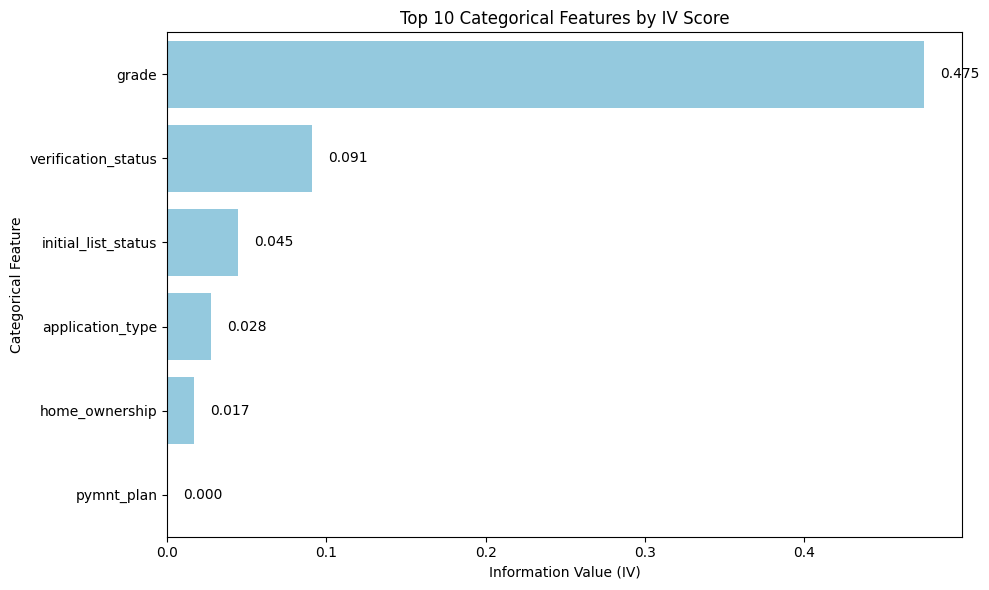

In [48]:

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Convert IV results to a DataFrame and sort
iv_cat_df = pd.DataFrame(list(iv_results_categorical.items()), columns=["feature", "iv"])
iv_cat_df = iv_cat_df.sort_values(by="iv", ascending=False).head(10)

# Plot
plt.figure(figsize=(10, 6))
barplot = sns.barplot(data=iv_cat_df, x="iv", y="feature", color='skyblue')

# Annotate IV score on each bar
for i, v in enumerate(iv_cat_df["iv"]):
    barplot.text(v + 0.01, i, f"{v:.3f}", color='black', va='center')

plt.title("Top 10 Categorical Features by IV Score")
plt.xlabel("Information Value (IV)")
plt.ylabel("Categorical Feature")
plt.tight_layout()
plt.show()


Compiled from IV Values shown from numerical and categorical variables, it seems that we can safely drop some un-useful features for credit risk modeling. Normally, credit risk models just require a few strong features with maximised predictive values. Furthermore, we can observe that the IV Score of `last_fico_score` seems too good to be true. Upon further research, I realised that it is leaky, since it refers to the last credit report pull FICO score throughout the lifepsan of a loan. In lieu of that, this feature shall be dropped as well. 



In [22]:
df.limit(10).toPandas()

,id,loan_amnt,term,int_rate,installment,grade,home_ownership,annual_inc,verification_status,issue_d,...,percent_bc_gt_75_bin,pub_rec_bankruptcies_bin,tax_liens_bin,tot_hi_cred_lim_bin,total_bal_ex_mort_bin,total_bc_limit_bin,total_il_high_credit_limit_bin,credit_history_years_bin,fico_score_bin,last_fico_score_bin
0,137356613,12400.0,36,12.73,416.20,B,OWN,35436.0,Verified,2018-07-01,...,1.0,1.0,1.0,0.0,1.0,4.0,0.0,0.0,2.0,3.0
1,136523079,3000.0,36,7.21,92.92,A,RENT,23000.0,Not Verified,2018-07-01,...,1.0,1.0,1.0,1.0,0.0,3.0,1.0,1.0,4.0,4.0
2,137549421,25000.0,36,6.11,761.80,A,MORTGAGE,118927.0,Not Verified,2018-07-01,...,1.0,1.0,1.0,3.0,0.0,3.0,0.0,4.0,3.0,3.0
3,135051542,1000.0,36,25.34,39.94,E,RENT,9479.0,Not Verified,2018-07-01,...,2.0,1.0,1.0,0.0,0.0,0.0,0.0,2.0,1.0,2.0
4,135639525,30000.0,60,25.81,894.85,E,MORTGAGE,81000.0,Verified,2018-07-01,...,3.0,1.0,1.0,1.0,3.0,3.0,2.0,4.0,3.0,1.0
5,136039530,1500.0,36,7.46,46.64,A,RENT,40000.0,Verified,2018-07-01,...,1.0,1.0,1.0,1.0,0.0,4.0,1.0,1.0,4.0,4.0
6,136602296,2600.0,36,13.56,88.31,C,OWN,25000.0,Verified,2018-07-01,...,1.0,1.0,1.0,2.0,3.0,3.0,3.0,3.0,4.0,4.0
7,137216003,20000.0,36,22.35,767.44,D,MORTGAGE,90000.0,Not Verified,2018-07-01,...,3.0,1.0,1.0,3.0,1.0,2.0,0.0,2.0,1.0,0.0
8,136601401,24000.0,60,16.91,595.31,C,MORTGAGE,120000.0,Not Verified,2018-07-01,...,1.0,1.0,1.0,4.0,4.0,4.0,4.0,4.0,4.0,3.0
9,137529372,4000.0,36,11.06,131.07,B,RENT,30000.0,Source Verified,2018-07-01,...,3.0,1.0,1.0,0.0,0.0,3.0,0.0,2.0,2.0,2.0


# 2. Feature Engineering Obtaining Interaction Features 
Now, I will be manually inspecting each column, to check if I can create any interaction features. Interaction features capture the joint effect of features, e.g. When a borrower has high `loan_amnt`, it seems OK. When he has a low `income`, he might have a higher risk. But when he has both a high `loan_amnt` and a low `income`, this may be a huge red flag. As such, combining features is extremely important for credit risk modeling. 
<br>



### 2.1 Obtaining Interaction Ratios 
Heading on to Interaction Ratios, the following features can be combined so our future models can capture the joint effect of both features. An efficient workflow would be to explore the dataset via different grouping/segments, to check if they have indeed a clear difference in risk levels. I will sample the data to simulate a big data environment, where the massive volumes of data make it almost impossible to visualise the entire dataset. 


### 2.2 Loan Amount x Income 
Borrowers with lower incomes, but apply for loans way above their financial capabilities is a red flag as well. We will want to check if their borrowed loan amount puts a toll on their ability to repay 

In [14]:
# loan_amnt_annual_inc_ratio (Principal sum relative to annual income)
# installment_term_annual_inc_ratio (how much is total repayment [principal + interest] is relative to annual income)
# revol_bal_annual_inc_ratio (how much of annual income are they using for debt, do they have financial ability to provide for themselves after debt?)

df = df.withColumn('loan_amnt_annual_inc_ratio', col('loan_amnt') / col('annual_inc')  )
df = df.withColumn('installment_term_annual_inc_ratio',  col('installment') * col('term') / col('annual_inc') )
df = df.withColumn('revol_bal_annual_inc_ratio',  col('revol_bal') / col('annual_inc') ) 

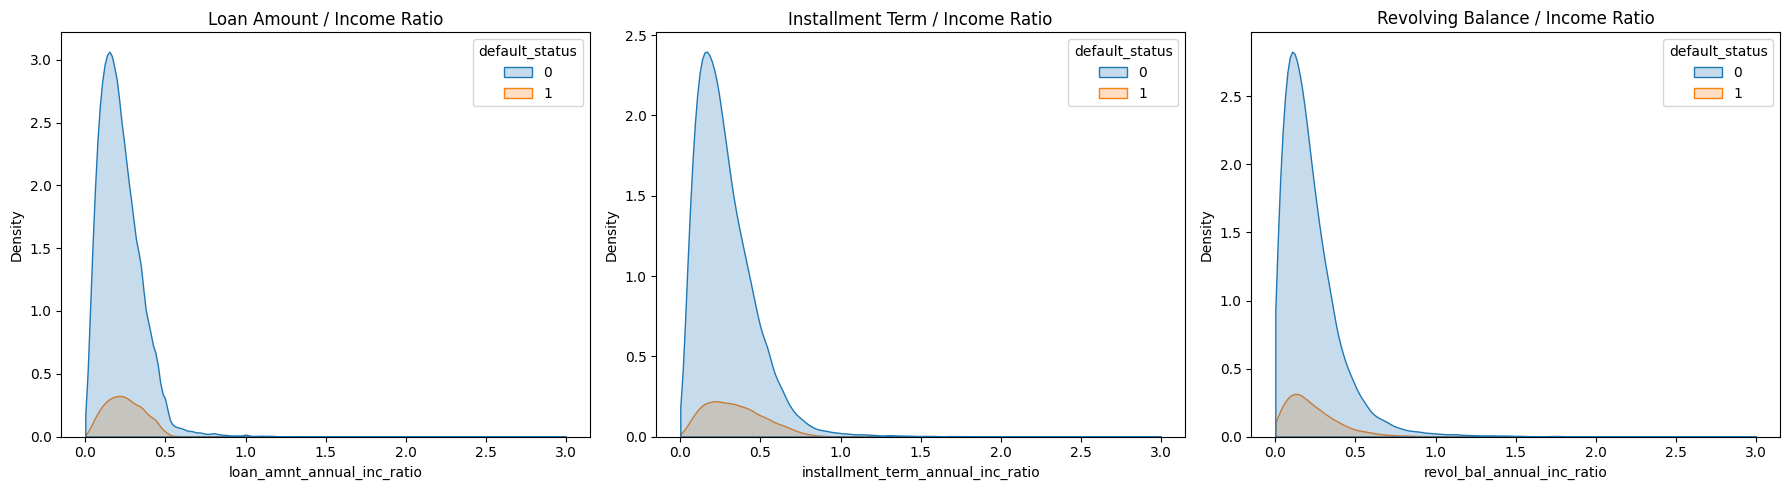

In [15]:
# Visualisation Code 
import matplotlib.pyplot as plt
import seaborn as sns

# Conventional Pyspark stratified sampling way -> Helps with class imbalance 
sample_pdf = df.select(
    col("loan_amnt_annual_inc_ratio"), 
    col("installment_term_annual_inc_ratio"), 
    col('revol_bal_annual_inc_ratio'), 
    col('default_status')
).sample(fraction=0.05, seed=42).toPandas()  

# Set up 3 subplots side-by-side
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot 1: loan_amnt / annual_inc
sns.kdeplot(data=sample_pdf, x="loan_amnt_annual_inc_ratio", hue="default_status", ax=axes[0], fill=True, clip=(0,3))
axes[0].set_title("Loan Amount / Income Ratio")

# Plot 2: installment * term / annual_inc
sns.kdeplot(data=sample_pdf, x="installment_term_annual_inc_ratio", hue="default_status", ax=axes[1], fill=True, clip=(0,3))
axes[1].set_title("Installment Term / Income Ratio")

# Plot 3: revol_bal / annual_inc
sns.kdeplot(data=sample_pdf, x="revol_bal_annual_inc_ratio", hue="default_status", ax=axes[2], fill=True, clip=(0,3))
axes[2].set_title("Revolving Balance / Income Ratio")

plt.tight_layout()
plt.show()

Shown above, it seems that defaulters borrow less relative to income, this seems counterintuitive as it is of common belief that defaulters often borrow more than their ability to repay loans. However, this may be due to outliers in income (common in credit risk datasets), causing the right-skewness of the distributions. To observe this better, let's attempt quantile binning to reduce the impact of extreme values. 

In [16]:
from pyspark.ml.feature import QuantileDiscretizer

features_to_bin = [
    ("loan_amnt_annual_inc_ratio", "loan_amnt_annual_inc_ratio_bin"),
    ("installment_term_annual_inc_ratio", "installment_term_annual_inc_ratio_bin"),
    ("revol_bal_annual_inc_ratio", "revol_bal_annual_inc_ratio_bin")
]

for input_col, output_col in features_to_bin:
    discretizer = QuantileDiscretizer(
        numBuckets=10,
        inputCol=input_col,
        outputCol=output_col,
        handleInvalid="skip"
    )
    df = discretizer.fit(df).transform(df)

In [17]:
from pyspark.sql.functions import avg

# 1. Loan Amount / Annual Income Ratio Bin
loan_bin_stats = df.groupBy("loan_amnt_annual_inc_ratio_bin") \
    .agg(avg("default_status").alias("default_rate")) \
    .orderBy("loan_amnt_annual_inc_ratio_bin")

# 2. Installment Term / Annual Income Ratio Bin
installment_bin_stats = df.groupBy("installment_term_annual_inc_ratio_bin") \
    .agg(avg("default_status").alias("default_rate")) \
    .orderBy("installment_term_annual_inc_ratio_bin")

# 3. Revolving Balance / Annual Income Ratio Bin
revol_bin_stats = df.groupBy("revol_bal_annual_inc_ratio_bin") \
    .agg(avg("default_status").alias("default_rate")) \
    .orderBy("revol_bal_annual_inc_ratio_bin")

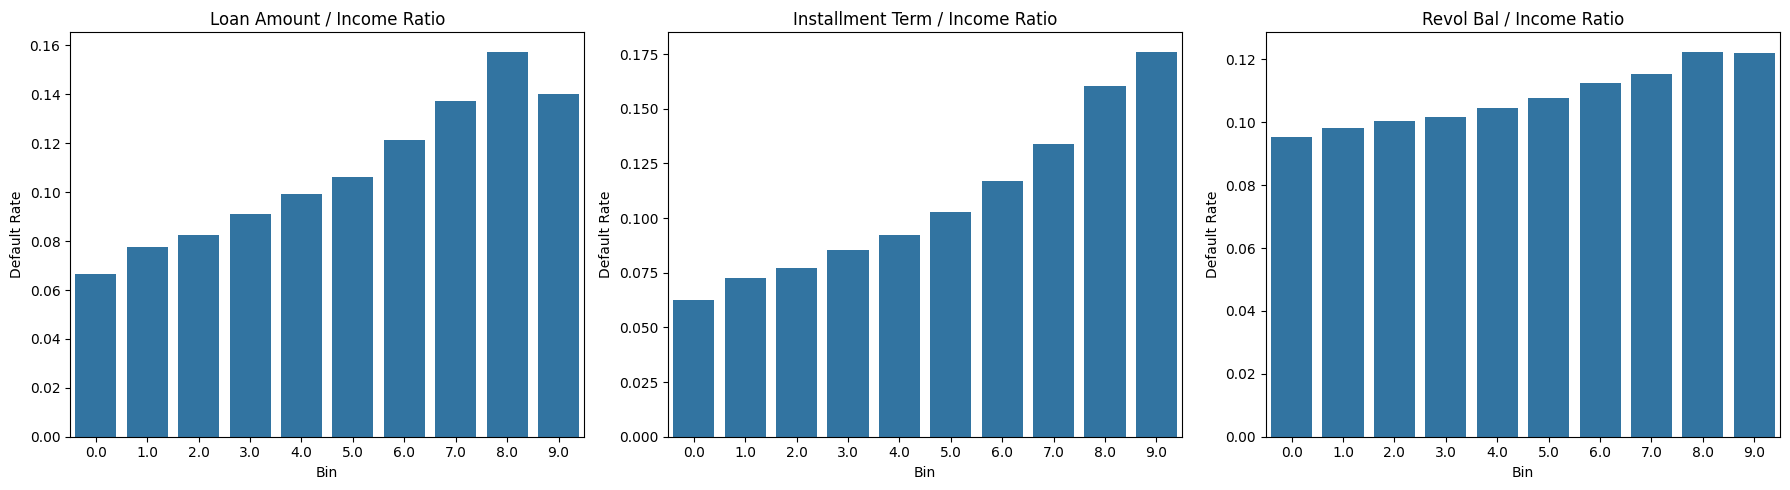

In [18]:
# Convert to Pyspark 
loan_pdf = loan_bin_stats.toPandas()
installment_pdf = installment_bin_stats.toPandas()
revol_pdf = revol_bin_stats.toPandas()

# Plot subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Loan Amount Ratio
sns.barplot(data=loan_pdf, x='loan_amnt_annual_inc_ratio_bin', y='default_rate', ax=axes[0])
axes[0].set_title('Loan Amount / Income Ratio')
axes[0].set_xlabel('Bin')
axes[0].set_ylabel('Default Rate')

# Installment Ratio
sns.barplot(data=installment_pdf, x='installment_term_annual_inc_ratio_bin', y='default_rate', ax=axes[1])
axes[1].set_title('Installment Term / Income Ratio')
axes[1].set_xlabel('Bin')
axes[1].set_ylabel('Default Rate')

# Revolving Balance Ratio
sns.barplot(data=revol_pdf, x='revol_bal_annual_inc_ratio_bin', y='default_rate', ax=axes[2])
axes[2].set_title('Revol Bal / Income Ratio')
axes[2].set_xlabel('Bin')
axes[2].set_ylabel('Default Rate')

plt.tight_layout()
plt.show()


As seen from the bar charts above, the 1st 2 features are monotonic (1-directional as default rate increases). Comparatively, the last feature shows a smaller increase of default rate across bins, rendering it a less useful feature. Let's take a mental note, since WoE and IV Feature Selection would automatically detect less useful features. We will drop it at one go then. 

### 2.3 Housing Situation x Financial Stress 
Next, upon inspecting the dataset, I thought that it might be a good idea to merge `home_ownership` and other features which showcase borrower's financial capabilities to predict credit risk accurately. For example,  a borrower who has a relatively lower `annual_inc` and rents his home may have a higher credit risk, compared to someone who owns his house and have the same `annual_inc`. Let's first check if this combination is meaningful via grouping. Other features I may find meaningful will be combined with `home_ownership` as well to observe their impact on credit risk. 

In [19]:
# loan_amnt
# annual_inc 
# revol_util 

from pyspark.sql.functions import concat_ws, col

features_to_bin1 = [
    ("loan_amnt", "loan_amnt_bin"),
    ("annual_inc", "annual_inc_bin"),
    ("revol_util", "revol_util_bin")
]

for input_col, output_col in features_to_bin1:
    discretizer1 = QuantileDiscretizer(
        numBuckets=5,
        inputCol=input_col,
        outputCol=output_col,
        handleInvalid="skip"
    )
    df = discretizer1.fit(df).transform(df)


for _, binned_col in features_to_bin1:
    interaction_col = f"home_ownership_{binned_col}_interaction"
    df = df.withColumn(
        interaction_col,
        concat_ws("_", col("home_ownership"), col(binned_col).cast("string")) # delimiter, RENT, 9 -> RENT_9 for loan_amnt means high loan amount for borrower who rents his apartment ... 
    )

In [20]:
interaction_cols = [
    "home_ownership_loan_amnt_bin_interaction",
    "home_ownership_annual_inc_bin_interaction",
    "home_ownership_revol_util_bin_interaction"
]


# Calculate default status for each interaction bin 
interaction_stats = []

# For each interaction column, calculate count of default / num_records in that grp = avg() 

# Output: stats_df = home_ownership_loan_amnt_bin_interaction | default_rate
for colname in interaction_cols:
    stats_df = df.groupBy(colname) \
                  .agg(avg("default_status").alias("default_rate")) \
                  .orderBy(colname)
    
    # Add column name so we know the source later
    stats_df = stats_df.withColumnRenamed(colname, "interaction_bin") \
                       .withColumn("feature", lit(colname))
    
    interaction_stats.append(stats_df)

# Stack all interaction stats DataFrames together
combined_stats = interaction_stats[0]

for datafr in interaction_stats[1:]:
    combined_stats = combined_stats.unionByName(datafr)

# Convert to pandas
combined_pdf = combined_stats.toPandas()

combined_pdf.head()

,interaction_bin,default_rate,feature
0,MORTGAGE_0.0,0.071589,home_ownership_loan_amnt_bin_interaction
1,MORTGAGE_1.0,0.081745,home_ownership_loan_amnt_bin_interaction
2,MORTGAGE_2.0,0.103020,home_ownership_loan_amnt_bin_interaction
3,MORTGAGE_3.0,0.107610,home_ownership_loan_amnt_bin_interaction
4,MORTGAGE_4.0,0.105177,home_ownership_loan_amnt_bin_interaction


### 2.4 Credit Activity 
Borrowers who are actively seeking for credit, yet have bad track records, such as recent delinquencies or financial stress can possibly be tracked by our model to flag risky borrowers/loans. 

In [22]:
# inq_last_6mths_fico_bin
# revol_util_fico_bin
# inq_last_6mths_delinq_2yrs_bin
# inq_last_6mths_pub_rec


# Binning features
features_to_bin2 = [
    ("inq_last_6mths", "inq_last_6mths_bin"),
    ("fico_score", "fico_bin"),
    ("delinq_2yrs", "delinq_2yrs_bin"), 
    ("pub_rec", "pub_rec_bin"), 
    ('pub_rec_bankruptcies', 'pub_rec_bankruptcies_bin'),
]

for input_col, output_col in features_to_bin2:
    discretizer = QuantileDiscretizer(
        numBuckets=5,
        inputCol=input_col,
        outputCol=output_col,
        handleInvalid="skip"
    )
    df = discretizer.fit(df).transform(df)



25/07/06 19:34:36 WARN QuantileDiscretizer: Some quantiles were identical. Bucketing to 3 buckets as a result.
25/07/06 19:34:38 WARN QuantileDiscretizer: Some quantiles were identical. Bucketing to 2 buckets as a result.
25/07/06 19:34:39 WARN QuantileDiscretizer: Some quantiles were identical. Bucketing to 2 buckets as a result.
25/07/06 19:34:40 WARN QuantileDiscretizer: Some quantiles were identical. Bucketing to 2 buckets as a result.


In [23]:
# Create interaction features for credit activity 
interaction_pairs = [
    ("inq_last_6mths_bin", "fico_bin"),
    ("revol_util_bin", "fico_bin"),
    ("inq_last_6mths_bin", "delinq_2yrs_bin"),
    ("inq_last_6mths_bin", "pub_rec_bin") , 
    ("inq_last_6mths_bin", "pub_rec_bankruptcies_bin")
]

# Create interaction features by concatenating the values of the two binned columns 
for col1, col2 in interaction_pairs:
    interaction_col = f"{col1}_{col2}_interaction"
    df = df.withColumn(
        interaction_col,
        concat_ws("_", col(col1).cast("string"), col(col2).cast("string"))
    )


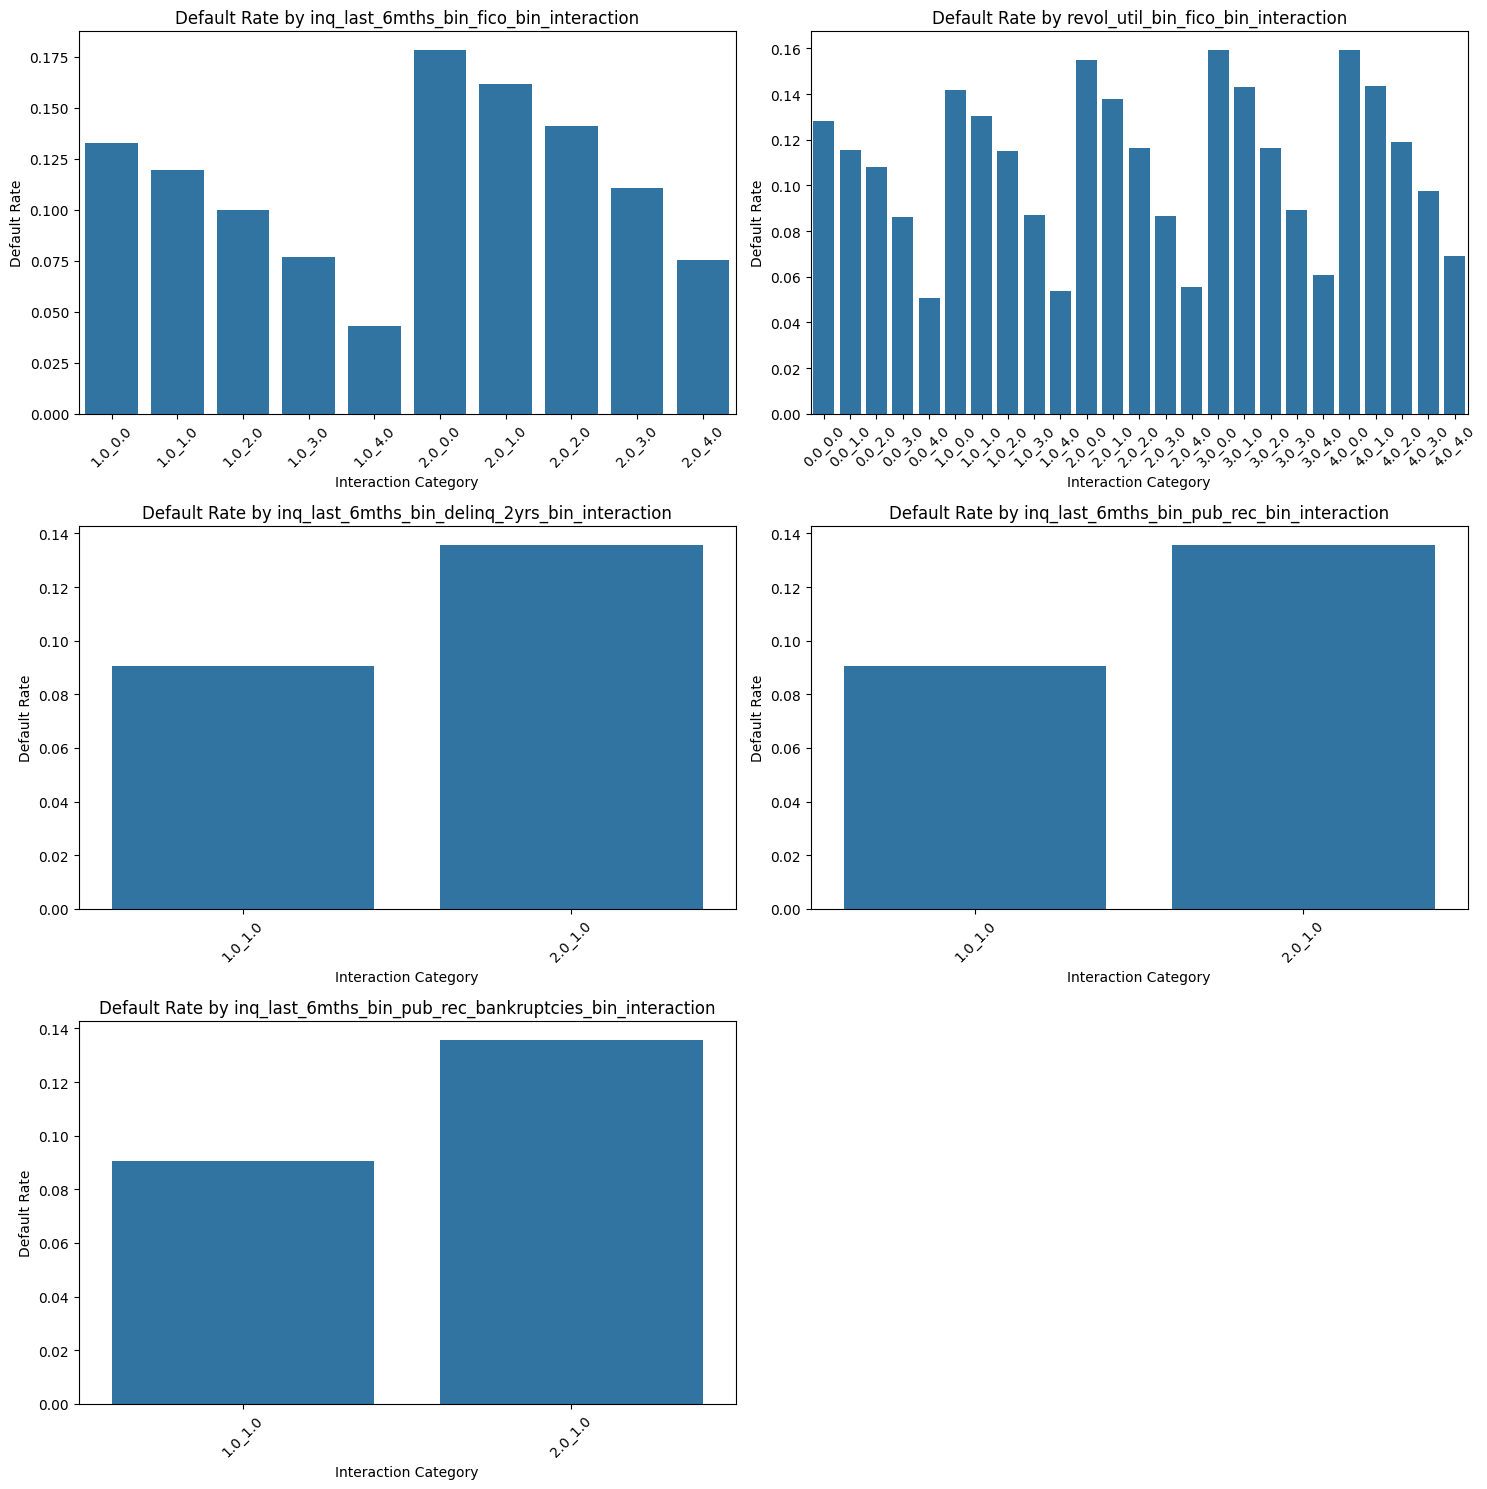

In [24]:
# List of interaction columns
interaction_cols = [
    f"{col1}_{col2}_interaction"
    for col1, col2 in interaction_pairs
]
import math 

# Set up the number of columns and compute rows dynamically
n_cols = 2
n_rows = math.ceil(len(interaction_cols) / n_cols)

# Create subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
axes = axes.flatten()  # Flatten in case it's a 2D array


subplot_df_list = []

# Obtain default rate for each interaction bin 
for interaction_col in interaction_cols: 
    subplot_df = df.groupBy(interaction_col) \
      .agg(avg("default_status").alias("default_rate")) \
      .orderBy(interaction_col).toPandas()
    
    subplot_df_list.append(subplot_df)

for i, subplot_df in enumerate(subplot_df_list): 
    interaction_col = subplot_df.columns[0]  # Get the interaction column name
    sns.barplot(data=subplot_df, x=interaction_col, y="default_rate", ax=axes[i])

    # Customisation of each subplot
    axes[i].set_title(f"Default Rate by {interaction_col}")
    axes[i].set_xlabel("Interaction Category")
    axes[i].set_ylabel("Default Rate")
    axes[i].tick_params(axis='x', rotation=45)


# Remove unused subplots
for j in range(len(subplot_df_list), len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()


As seen above, it seems that we have found out really interesting trends that fit the real world context. High number of credit inquiries (signfies financial strain of the borrower), with low FICO scores have a signficantly higher default rate than the rest of the bins. Also, it seems that revolving utilisation rate doesn't add much value to one's credit risk / default rate compared to FICO bins. 

Also, it seems that higher number of inquries seem to correspond with higher default rates. Now that we have a general understanding of which features / interaction features are useful for PD Modeling, we shall leave the work to WoE/IV Feature Selection to help us identify the features which are essential for PD Modeling. 

# 3. Feature Selection II 